# **DDPM with MiniAI (version 3)** 

In [1]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [2]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

# Going back to the "bug" discussed in NB 17, we thought we needed imagesto be in the range (-1, 1)
# Previously, we had b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]] -  which was incorrect 
# and degraded performance.
# Interestingly *2-1 resulting in an input range of (-1, 1) doesn't really have a solid theoretical foundation - apart from
# "well everybody does it this way".
# A simple, and seemingly intuitive fix is to have neatly centered inputs, while decreasing the input range from (-1, 1) to (-0.5, 0.5)
# so we go from a range of 2 to a range of 1, with properly centered inputs.
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

bs = 512
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [4]:
from types import SimpleNamespace

def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

The Linear Scheduler can be replaced with the Cosine Scheduler which results in better training outcomes.

In [5]:
# Changing the alphabar function is all that is required since it controls the total amount of noise
# in the system.
def abar(t, T): return (t/T*math.pi/2).cos()**2

In [6]:
def cos_sched(n_steps=1000):
    ts = torch.linspace(0, n_steps-1, n_steps)
    ab = abar(ts,n_steps)
    alp = ab/abar(ts-1,n_steps) # alphabar or abar allows us to backup into our schedule.
    return SimpleNamespace(a=alp, abar=ab, sig=(1-alp).sqrt())

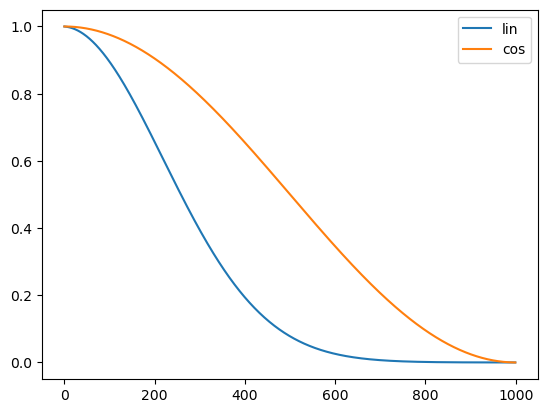

In [7]:
# Comparing the two schedules, we can see that the Linear version has a lot of time steps at 0
# Whereas Cosine has a very steady gradient for step updates.
lin_abar = linear_sched().abar
cos_abar = cos_sched().abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

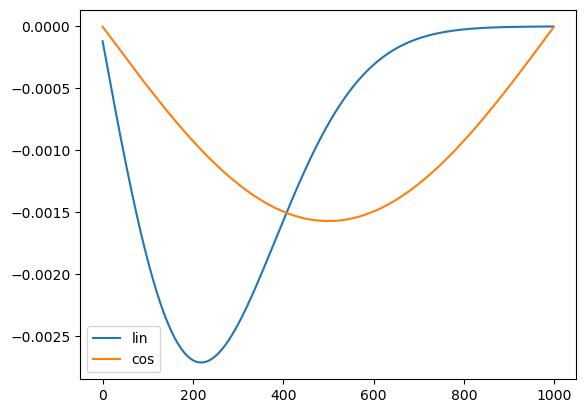

In [8]:
# Comparing the slopes, again Cosine is vastly better than Linear.
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

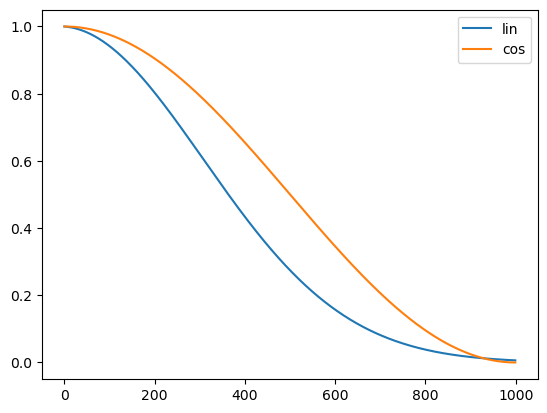

In [9]:
# However, we can avoid having to create a new class to save time and simply update the default Linear
# scheduler's betamax to 0.01 to mimic the Cosine scheduler.
lin_abar = linear_sched(betamax=0.01).abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

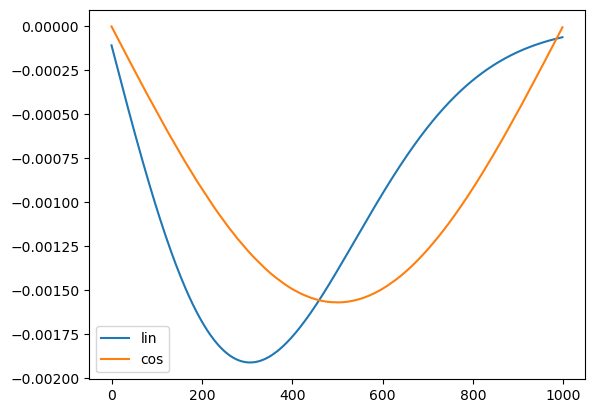

In [10]:
# The new betamax results in an improved slope as well.
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

In [11]:
n_steps = 1000
lin_abar = linear_sched(betamax=0.01) # Training with a new betamax as a path of least resistance.
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [12]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [13]:
dt = dls.train
xb,yb = next(iter(dt))

In [14]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([ 26, 335, 620, 924, 950, 113, 378,  14, 210, 954, 231, 572, 315, 295,
        567, 706, 749, 876,  73, 111, 899, 213, 541, 769, 287])

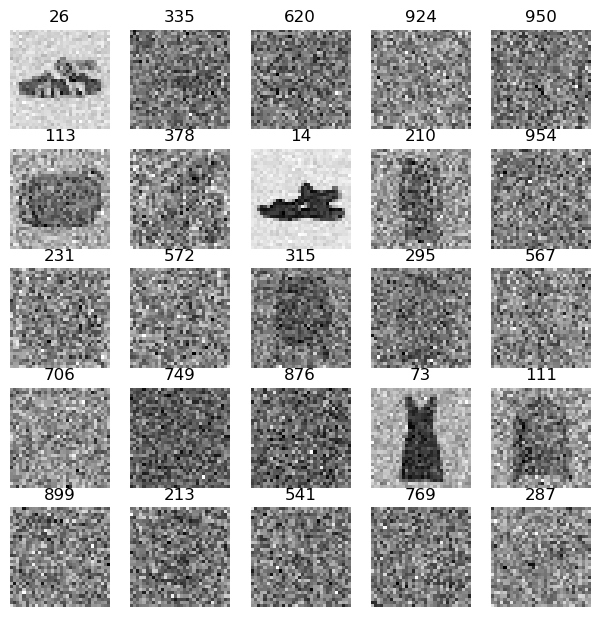

In [15]:
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25], imsize=1.5, titles=titles)

What is encouraging is the fact that noisified images have also improved in their recognizability from previous iterations. Apart from this, we will proceed with our training steps from before.

## **Training**

In [16]:
from diffusers import UNet2DModel

In [17]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [18]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [19]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=nw)

In [20]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

Doubling the channels from earlier runs and increasing the number of epochs.

In [22]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.201,0,train
0.040,0,eval
0.035,1,train
0.035,1,eval
0.031,2,train
0.030,2,eval
0.029,3,train
0.030,3,eval
0.028,4,train
0.031,4,eval


/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


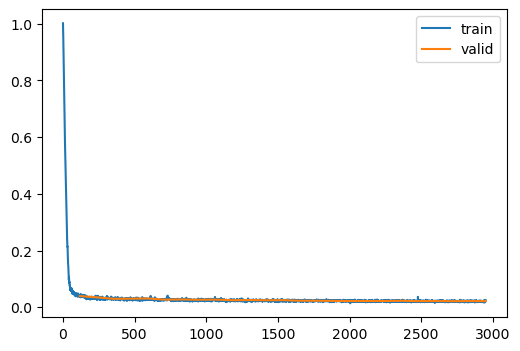

In [23]:
learn.fit(epochs)

In [21]:
mdl_path = Path('models')

In [22]:
#torch.save(learn.model, mdl_path/'fashion_ddpm3_25.pkl')

In [23]:
model = torch.load(mdl_path/'fashion_ddpm3_25.pkl').cuda()

In [24]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [25]:
n_samples = 512

In [26]:
%%time
samples = sample(model, (n_samples, 1, 32, 32))

/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


CPU times: user 4min 1s, sys: 2.55 s, total: 4min 3s
Wall time: 4min 2s


In [27]:
s = (samples[-1]*2)
s.min(), s.max()

(tensor(-1.0932), tensor(1.3197))

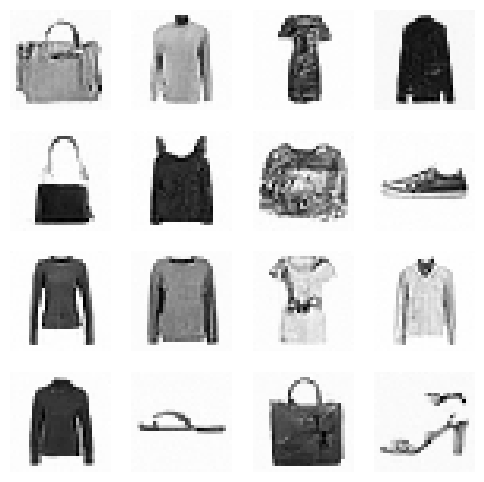

In [28]:
show_images(s[:16], imsize=1.5)

### Load Classification Model, Run Batch Transforms and Use Model's Pooling Layer for FID

In [29]:
@inplace
def transformi2(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds2 = dsd.with_transform(transformi2)
dls2 = DataLoaders.from_dd(tds2, bs, num_workers=fc.defaults.cpus)

cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

In [30]:
from miniai.fid import ImageEval

In [31]:
ie = ImageEval(cmodel, dls2, cbs=[DeviceCB()])

In [32]:
ie.fid(s)

10.2735595703125

In [33]:
s.min(),s.max()

(tensor(-1.0932), tensor(1.3197))

In [34]:
ie.fid(xb*2)

6.70416259765625

### **Speeding Up With Skip Sampling**

The most recent run of the `sample()` function completed in approximately 4 mins. Speeding up this part of the model's pipeline is the next logical step.

With the current `n_steps=1000`, the function's `for` loop is called 1000 times. This means that...

```
noise = model((x_t, t_batch))
```

...is also being called a 1000 times. The model iterates in very small steps, and the noise remains the same for a large proportion of them. A tiny change of running the model after every 3rd step should speed things up without effecting sampling performance.

In [35]:
@torch.no_grad()
def sample_skip(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t>0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1] if t>0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        if t%3==0 or t<50: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise) / alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu().float())
    return preds

In [36]:
%%time
samples = sample_skip(model, (n_samples, 1, 32, 32))

CPU times: user 1min 31s, sys: 1.3 s, total: 1min 32s
Wall time: 1min 29s


This sped things up quite nicely!

In [37]:
s = (samples[-1]*2)

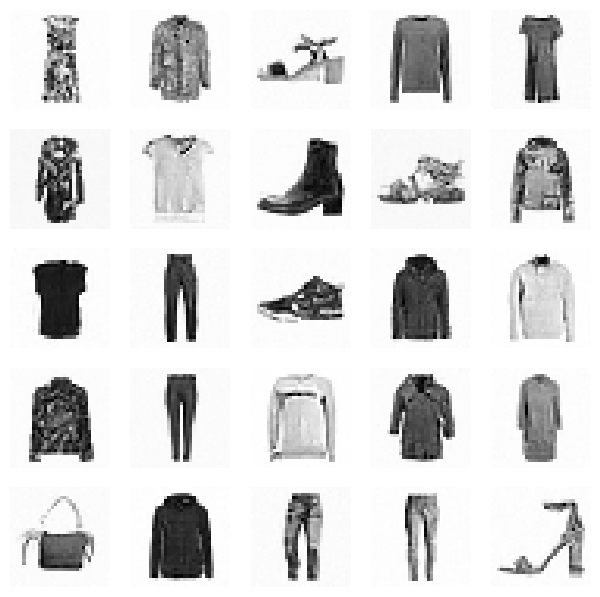

In [38]:
show_images(s[:25], imsize=1.5)

There is no discernable difference in samples upon visual inspection.

In [39]:
# Checking FID and KID for the new samples
ie.fid(s)

13.21282958984375

And there is no significant difference in FID scores as well. This means we are on the right track.

We can experiment further with the schedule for calling the model in the sampling function. 

In [40]:
@torch.no_grad()
def sample2(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    sample_at = {t for t in range(n_steps) if (t+101)%((t+101)//100)==0}
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t in sample_at: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        if t in sample_at: preds.append(x_t.float().cpu())
    return preds

In [41]:
%%time
samples = sample2(model, (n_samples, 1, 32, 32))

CPU times: user 1min 14s, sys: 538 ms, total: 1min 15s
Wall time: 1min 13s


In [42]:
s = (samples[-1]*2)

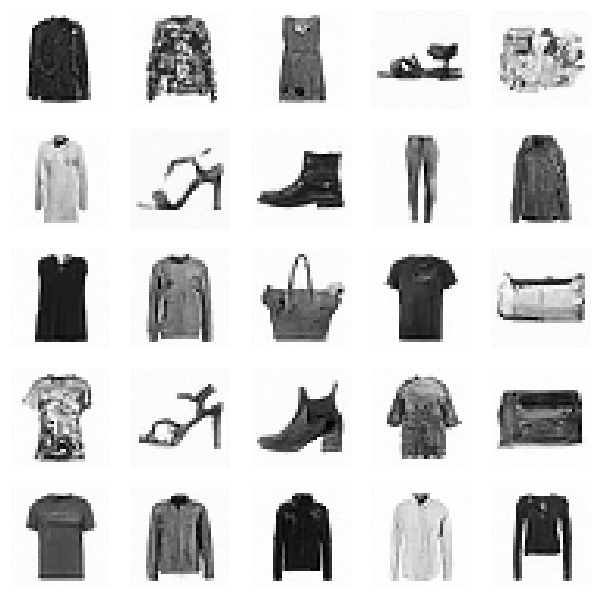

In [43]:
show_images(s[:25], imsize=1.5)

In [44]:
ie.fid(s)

13.2835693359375